In [ ]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pré-processamento e modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# Técnicas para lidar com desbalanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Configurações de visualização
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


In [ ]:
# Caminho do dataset
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# Carregar dataset
df = pd.read_csv(file_path)

# Visualizar as primeiras linhas
df.head()


In [ ]:
print("Formato do dataset:", df.shape)
print("\nTipos de dados e valores ausentes:")
print(df.info())
print("\nResumo estatístico das variáveis numéricas:")
df.describe()


/tmp/ipython-input-1411314573.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Class', data=df, palette=['lightblue', 'red'])


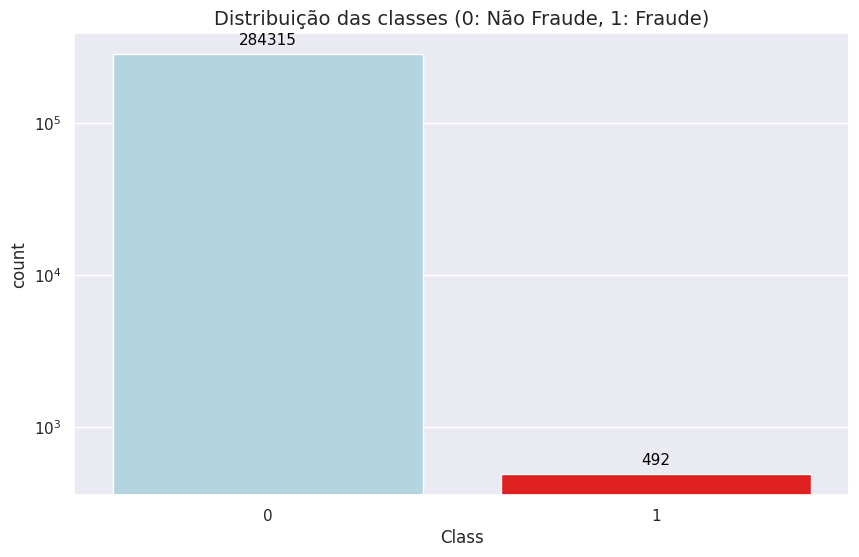


Proporção de fraudes: 0.1727%


In [ ]:
# Contagem de cada classe
counts = df['Class'].value_counts()

# Visualização
ax = sns.countplot(x='Class', data=df, palette=['lightblue', 'red'])
plt.title('Distribuição das classes (0: Não Fraude, 1: Fraude)')
plt.yscale('log')  # Escala logarítmica para destacar a diferença

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black',
                xytext=(0, 10), textcoords='offset points')

plt.show()

print(f"\nProporção de fraudes: {counts[1] / counts.sum():.4%}")


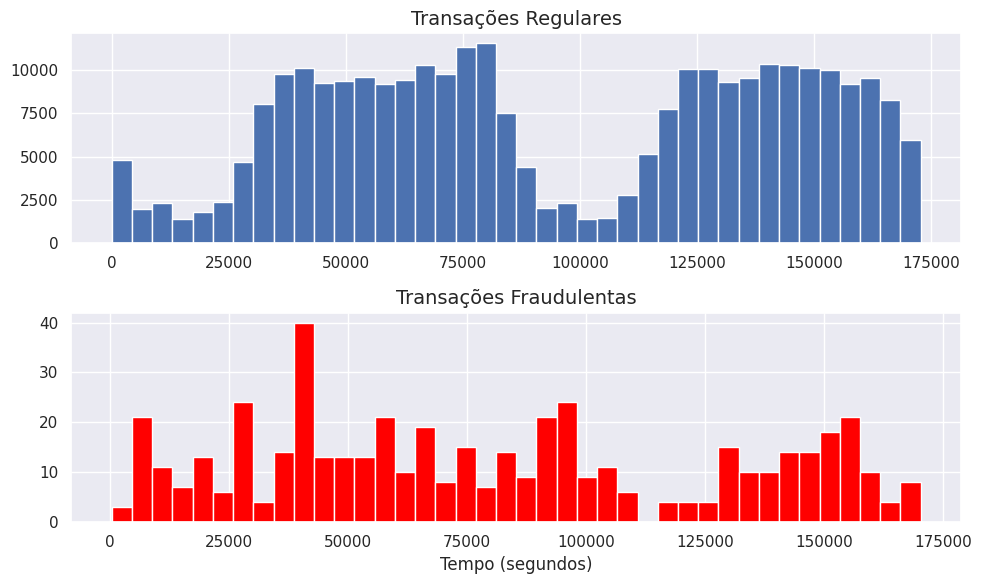

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].hist(df[df['Class']==0]['Time'], bins=40)
ax[0].set_title('Transações Regulares')
ax[1].hist(df[df['Class']==1]['Time'], bins=40, color='red')
ax[1].set_title('Transações Fraudulentas')
ax[1].set_xlabel('Tempo (segundos)')
plt.tight_layout()
plt.show()


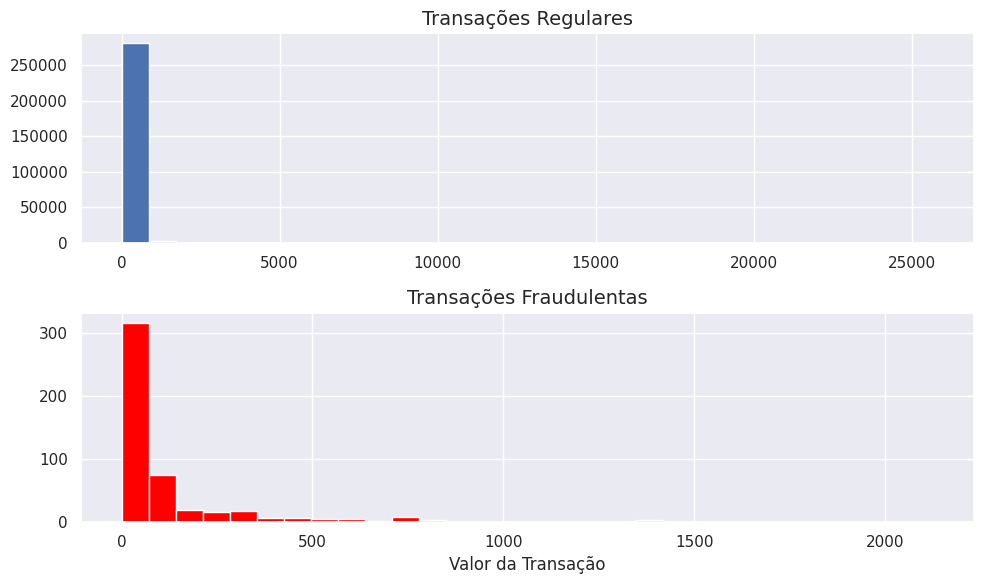

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].hist(df[df['Class']==0]['Amount'], bins=30)
ax[0].set_title('Transações Regulares')
ax[1].hist(df[df['Class']==1]['Amount'], bins=30, color='red')
ax[1].set_title('Transações Fraudulentas')
ax[1].set_xlabel('Valor da Transação')
plt.tight_layout()
plt.show()


In [12]:
# Separar features e target
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# Normalizar o valor das transações
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])


In [ ]:
# Divisão treino e teste antes do balanceamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Antes do SMOTE:", y_train.value_counts())
print("\nDepois do SMOTE:", y_train_res.value_counts())


Antes do SMOTE: Class
0    199020
1       344
Name: count, dtype: int64

Depois do SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64


In [16]:
# Inicializar modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Treinar e armazenar resultados
results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    roc = roc_auc_score(y_test, y_pred)
    results[name] = roc
    print(f"{name} - AUC: {roc:.4f}")


Logistic Regression - AUC: 0.9277
Random Forest - AUC: 0.8918


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:05:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - AUC: 0.9052


In [ ]:
# Melhor modelo
best_model = max(results, key=results.get)
print(f"\nMelhor modelo: {best_model}")

# Avaliação detalhada
y_pred = models[best_model].predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


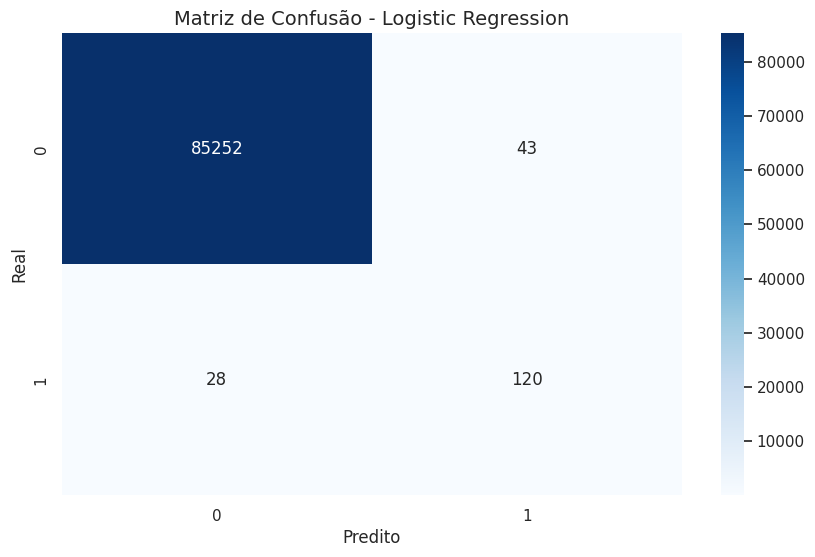

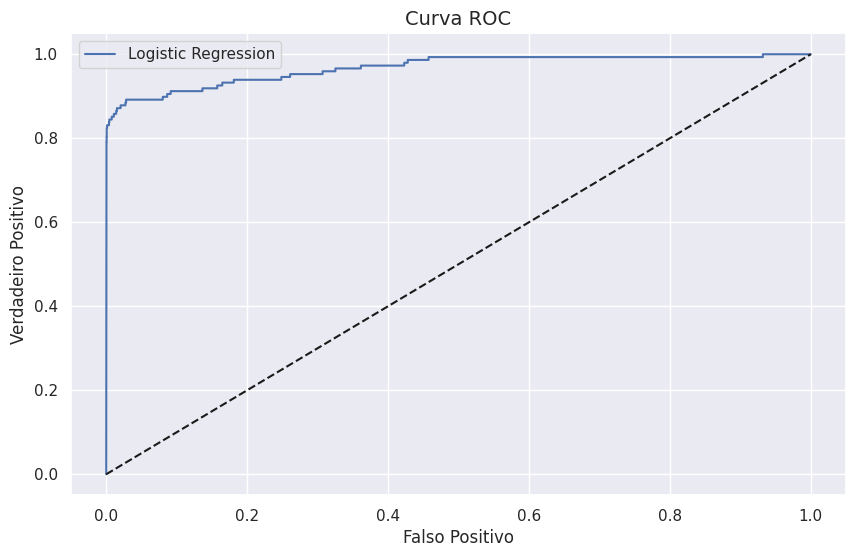

In [17]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de Confusão - {best_model}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, models[best_model].predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f"{best_model}")
plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC")
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.legend()
plt.show()
